### This project is aimed to classify images of Telgu movie actors, as dubded  south indian movies are becoming more popular across india.
### Many people are unable to identify these movie actors. Therefore machine learing model will be build to classify telgu movie actors.
### We will use SVM for buidling this machine learing model 

#### Dataset for this project is prepared by downloading images of 3 actors using Fatkun Batch Download image exension of crome

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

#### We will read images from dataset using cv2  

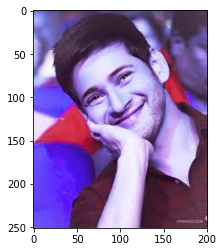

In [7]:
 #reading images
img=cv2.imread('D:/pandasdataset/project/image_classifier/dataset/mahesh_babu/mahesh_babu001.jpg')
plt.imshow(img)

#### We will crop image with the help of cv2. CasCadeClassifier
#### opencv folder containing xml files for the same is downloaded from stackoverflow

#### defining function to crop the images. Image will be return only if two eyes are visible

In [8]:
face_cascade = cv2.CascadeClassifier('D:/pandasdataset/project/image_classifier/opencv/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('D:/pandasdataset/project/image_classifier/opencv/haarcascade_eye.xml')

def get_cropped_image(path):
    img=cv2.imread(path)
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_cascade.detectMultiScale(gray,1.3,5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        #if len(eyes) >= 2:
        return roi_color

#### lets define path for imgaes and path where cropped images to be saved

In [9]:
path_to_data='D:/pandasdataset/project/image_classifier/dataset/'
path_to_cropped_data='D:/pandasdataset/project/image_classifier/dataset/cropped/'

#### lets use os package to scan the folders

In [12]:
import os
img_dirs=[]
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

#### If cropped folder contains any existing data, removing it using shutil and making new folders using os

In [13]:
import shutil
if os.path.exists(path_to_cropped_data):
    shutil.rmtree(path_to_cropped_data)
os.mkdir(path_to_cropped_data)

#### will crop all the images and stored them in cropped folder one by one

In [14]:
cropped_image_dirs =[]
celebrity_file_names_dict={}

for img_dir in img_dirs:
    count=1
    celebrity_name=img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name]=[]
    
    for entry in os.scandir(img_dir):
        roi_color=get_cropped_image(entry.path)
        
        if roi_color is not None:
            cropped_folder=path_to_cropped_data+celebrity_name
            
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print('generating cropped images in folder: ',cropped_folder)
            cropped_file_name=celebrity_name+str(count)+'.jpg'
            cropped_file_path=cropped_folder+'/'+cropped_file_name
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count+=1

generating cropped images in folder:  D:/pandasdataset/project/image_classifier/dataset/cropped/mahesh_babu
generating cropped images in folder:  D:/pandasdataset/project/image_classifier/dataset/cropped/Samantha_Akkineni
generating cropped images in folder:  D:/pandasdataset/project/image_classifier/dataset/cropped/vijay_devarakonda


#### image processing will be done using wavelet transform. Function is taken from opencv documentation

In [15]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)
    
    return imArray_H

#### preprocessing data using wavelet transform function and resizing all the images
#### class label will be append using Category index

In [16]:
DATADIR="D:\pandasdataset\project\image_classifier\dataset\cropped"
CATEGORIES =["mahesh_babu","Samantha_Akkineni","vijay_devarakonda"]

training_data=[]

def create_training_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR,category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                img_hair=w2d(img_array,'db1',5)
                new_array=cv2.resize(img_array,(150,150))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()

In [17]:
print(len(training_data))

176


#### we will shuffle the data so that model will be properly train 

In [18]:
import random
random.shuffle(training_data)

#### separating features and target . converting x into array

In [22]:
X=[]
y=[]

In [23]:
for features, label in training_data:
    X.append(features)
    y.append(label)
X=np.array(X).reshape(len(X),67500).astype(float)
X.shape

(176, 67500)

#### lets perform normalization as we are going to use SVM

In [24]:
X=X/255

In [25]:
X[0]

array([0.04313725, 0.04705882, 0.03921569, ..., 0.25098039, 0.23921569,
       0.20784314])

In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#### performing SMOTE to balance the class labels

In [27]:
from imblearn.over_sampling import SMOTE
smote=SMOTE()
X_SMOTE,Y_SMOTE=smote.fit_sample(X,y)

#### spliting the dataset

In [34]:
x_train,x_test,y_train,y_test=train_test_split(X_SMOTE,Y_SMOTE,test_size=0.25)

In [35]:
sv_model=SVC(kernel='rbf',C=5,gamma='scale')

#### training the model

In [36]:
sv_model.fit(x_train,y_train)
sv_model.score(x_test,y_test)

0.8

#### model score is 0.8 which is descend, as we are not using neural network

#### printng classification report

In [37]:
print(classification_report(y_test,sv_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.69      0.79      0.73        14
           1       0.80      0.86      0.83        14
           2       0.89      0.77      0.83        22

    accuracy                           0.80        50
   macro avg       0.79      0.81      0.80        50
weighted avg       0.81      0.80      0.80        50



#### performing cross fold validation

In [38]:
from sklearn.model_selection import cross_val_score
clf_score=cross_val_score(sv_model,x_train,y_train,cv=4)
print(clf_score)
clf_score.mean()

[0.86486486 0.72972973 0.83783784 0.81081081]


0.8108108108108109

#### cross fold validation result are satisfying